# SchW-BERT-GAN データ前処理
theorytabデータセットを使ったSchW-BERT-GAN用データの処理  
melody, chord, metaをまとめたデータをbundleと呼び，その数をbundle_numとする

In [1]:
import os
import hickle as hkl
import numpy as np
import pandas as pd
from pypianoroll import Multitrack, Track
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool, cpu_count
print(f"{cpu_count()} cpus are available.")

# カレントディレクトリをリポジトリ直下にして自家製モジュールをimport
while os.getcwd().split('/')[-1] != 'schwbert': os.chdir('..')
print('current dir:', os.getcwd())
from utils import Timer, Sampler, grid_plot
from preparation.bundle import Bundle, PypianorollBundler
from preparation.processor import BundlesProcessor, SequentialBundlesProcessor

32 cpus are available.
current dir: /root/schwbert


In [2]:
base_dir = "../datasets"
theorytab_dir = os.path.join(base_dir, "theorytab")
input_dir = os.path.join(theorytab_dir, "pianoroll")
input_csv = os.path.join(theorytab_dir, "theorytab.csv")

schwbert_dir = os.path.join(base_dir, "schwbert")
output_base_dir = os.path.join(schwbert_dir, "data")
output_dir = os.path.join(output_base_dir, "theorytab")
output_path = os.path.join(output_dir, "original.hkl")

for directory in [schwbert_dir, output_base_dir, output_dir]:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [3]:
df = pd.read_csv(input_csv)
df = df[(df["nokey"] == False) & (df["time_signature"] == "4/4")]
df = df[df["has_melody_track"] & df["has_chord_track"]]
df = df.reset_index()

sampler = Sampler(base_dir=input_dir, dataframe=df)
print(df.shape)
df.head()

(16386, 23)


,index,Unnamed: 0,path,artist,song,section,nokey,key_signature,estimated_key_signature,in_scale_rate,...,lowest_melody,highest_chord,lowest_chord,bpm,time_signature,beats,bars,time,has_melody_track,has_chord_track
0,0,0,q/quincy-jones-and-his-orchestra/soul-bossa-no...,quincy-jones-and-his-orchestra,soul-bossa-nova,chorus,False,Bb Major,Bb Major,0.88278,...,65.0,63.0,43.0,146,4/4,48,12,19.73,True,True
1,2,2,q/queen-and-bowie/under-pressure/intro-and-ver...,queen-and-bowie,under-pressure,"intro,verse",False,D Major,D Major,1.00000,...,57.0,57.0,45.0,120,4/4,32,8,16.00,True,True
2,5,5,q/queen-and-bowie/under-pressure/intro_key.mid,queen-and-bowie,under-pressure,intro,False,D Major,D Major,1.00000,...,57.0,61.0,50.0,240,4/4,32,8,8.00,True,True
3,8,8,q/queen/the-show-must-go-on/intro-and-verse_ke...,queen,the-show-must-go-on,"intro,verse",False,B Major,B minor,0.64627,...,70.0,59.0,42.0,83,4/4,57,14,40.48,True,True
4,10,10,q/queen/the-show-must-go-on/bridge_key.mid,queen,the-show-must-go-on,bridge,False,C Major,A minor,1.00000,...,57.0,60.0,43.0,84,4/4,24,6,17.14,True,True


id: 0
path: q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid


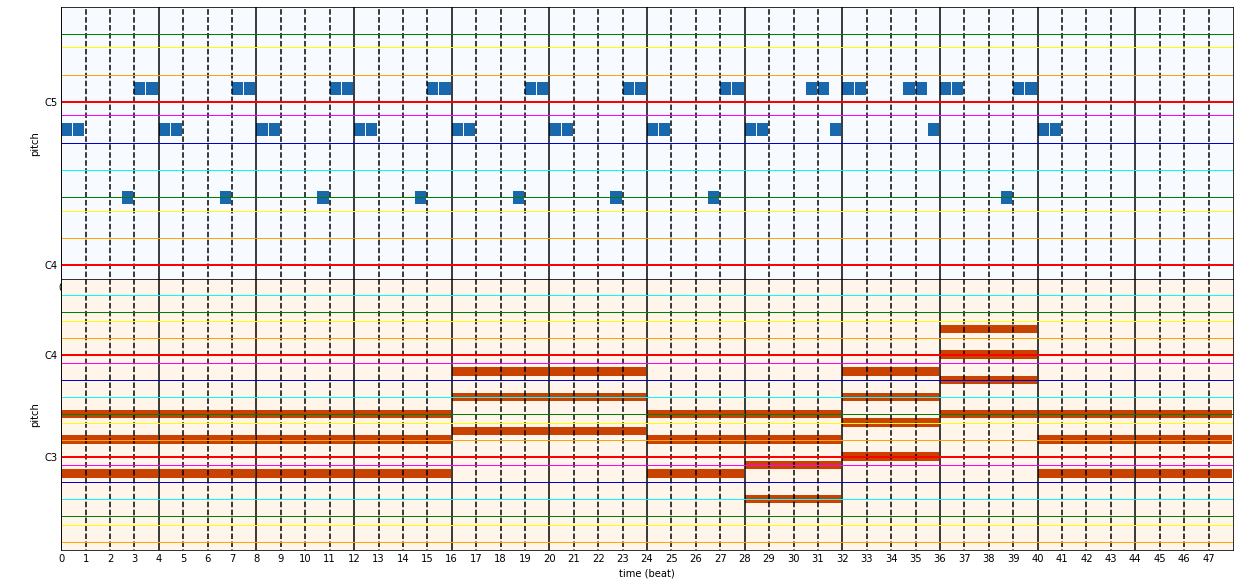

In [4]:
ppr = sampler.ppr(with_row=False)
grid_plot(ppr)

# original
- 全体的なこと
    - resolutionを12にして音符の切れ目を一番後ろ空白にする
    - スケール外の音が生成されてしまうのでトランスポーズによる水増しを行わない
    - 長さの固定
        - 16小節未満のものは残りスペースのPAD部分を1にする
        - 16小節を超えるものは16小節ごとに分割
        - 4小節未満のものは使わない
        - 複数のphraseが得られることがあるので，並列処理の返り値はリストのリスト
            - あとで直列にする
- メロディのこと
    - (768, 67)
    - 提示されているkeyはあてにならないので，estimated_keyに合わせてCもしくはAmへトランスポーズ
    - MIDI音程を36～99(99を含む, C2~D#7)の64ピッチ以内にシフトし， ピッチ方向は64入力のモデルで学習
    - id=64は休符． 音程がない部分の音程を1にする
    - id=65の音程はマスク用なので0にしておく
    - id=66の音程はPAD
    - メロディ密度が全体の半分未満のデータは削除
- コードのこと
    - (768, 13)
    - few-hot vectorを使用 -> 12で割って得られたピッチをそのまま使う. 展開形などにも対応できる
    - id=12の音程はPAD
    - midinetのように，後ろ(先頭は前へ)に伸ばすことで全てのステップで何かしら鳴っているようにする
- メタ情報のこと
    - 辞書型で保存
    - file_name
    - bars_range (0スタート) ex. 0-16
    - bpm
    - original_bars (小節数)
    - bars
    - beat_resolution
    - beats_in_bar

### 処理の手順
melody(numpy配列), chord(numpy配列), meta(辞書)がBundleになったリストを取得  
- PypianorollBundler.bundle(ppr, row)
  
Bundleに施すProcessor
- RemoveShortBundles
- Binarize
- DownBeatResolution
    - meta['beat_resolution']を更新
- Transpose
- メロディに影響するもの
    - TrimMelodyInRange
    - AddSpetialPitchesToMelody
- コードに影響するもの
    - TranslateChordIntoPitchClasses
    - AddSpetialPitchesToChord
- Padding
    - meta['bars']を設定

### Bundleへ分割

In [5]:
bundler = PypianorollBundler()

動作確認

In [6]:
ppr, row = sampler.ppr()

with Timer():
    bundles = bundler.bundle(ppr, row)

print(f"{len(bundles)} bundle(s)")
bundle = bundles[0]
print(f"melody shape: {bundle.melody.shape}")
print(f"chord shape: {bundle.chord.shape}")
bundle.get_dict()

id: 0
path: q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid
0.000388
1 bundle(s)
melody shape: (1152, 128)
chord shape: (1152, 128)


{'melody': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'chord': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'meta': {'range_from': 0,
  'range_for': 12,
  'original_bars': 12,
  'beat_resolution': 24,
  'beats_in_bar': 4,
  'path': 'q/quincy-jones-and-his-orchestra/soul-bossa-nova/chorus_key.mid',
  'bpm': 146,
  'original_key': 'Bb Major'}}

### 短いbundleを削除する

In [7]:
class RemoveShortBundles(BundlesProcessor):
    """
    初期化引数threshold_barsより小さい小節数のBundleを削除
    """
    def __init__(self, threshold_bars=4):
        self.threshold_bars = threshold_bars

    def process_bundle(self, bundle):
        if bundle.meta["original_bars"] < self.threshold_bars:
            return None
        return bundle

動作確認

In [8]:
remove_short_bundles = RemoveShortBundles()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

with Timer():
    bundles = remove_short_bundles(bundles)

len(bundles)

path: q/queen/bohemian-rhapsody/bridge_key.mid
0.000011


1

### 二値化する

In [9]:
class Binarize(BundlesProcessor):
    """
    melody, chordをboolへ変換
    ベロシティが0ならFalse,1以上ならTrueとなる
    """
    def process_bundle(self, bundle):
        bundle.melody = bundle.melody.astype(bool)
        bundle.chord = bundle.chord.astype(bool)
        return bundle

動作確認

In [10]:
binarize = Binarize()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

print(bundles[0].melody.dtype)

with Timer():
    bundles = binarize(bundles)

print(bundles[0].melody.dtype)

path: q/queen/bohemian-rhapsody/bridge_key.mid
uint8
0.000444
bool


### beat_resolutionを下げる

In [11]:
class DownBeatResolution(BundlesProcessor):
    """
    melody, chordのbeat_resolutionを下げる
    metaのbeat_resolutionも更新される
    """
    def __init__(self, resolution_to, resolution_from=None, fill_mode=False):
        self.res_to = resolution_to
        self.fill_mode = fill_mode

    def down_resolution(self, nproll, step_width):
        result = nproll[::step_width]
        if not self.fill_mode:
            note_existence = nproll.astype(bool)
            for s in range(1, step_width):
                result *= note_existence[s::step_width]
        return result
    
    def process_bundle(self, bundle):
        res_from = bundle.meta['beat_resolution']
        
        if self.res_to >= res_from:
            raise ValueError(f"Target resolution ({self.res_to}) must be \
                             smaller than the original resolution ({res_from})")
        
        step_width = res_from // self.res_to
        
        bundle.melody = self.down_resolution(bundle.melody, step_width)
        bundle.chord = self.down_resolution(bundle.chord, step_width)
        bundle.meta['beat_resolution'] = self.res_to
        
        return bundle

動作確認

In [12]:
down_beat_resolution = DownBeatResolution(12)

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

bundle_id = 0
print(bundles[bundle_id].meta['beat_resolution'])
print(bundles[bundle_id].melody.shape)
print(bundles[bundle_id].chord.shape)

with Timer():
    bundles = down_beat_resolution(bundles)

print(bundles[bundle_id].meta['beat_resolution'])
print(bundles[bundle_id].melody.shape)
print(bundles[bundle_id].chord.shape)

path: q/queen/bohemian-rhapsody/bridge_key.mid
24
(1536, 128)
(1536, 128)
0.000774
12
(768, 128)
(768, 128)


### CまたはAmへトランスポーズする

In [13]:
class Transpose(BundlesProcessor):
    """
    to_keyはメジャースケールにおける主音
    例えば to_key=0 のとき, C minor を渡せば A minor へトランスポーズする
    変更元のkeyを後で変更できるのでインスタンスを再生成しなくていい
    変換後シフト量が取得できるので，別のトラックのシフトに再利用できる
    """
    def __init__(self, from_key_name="C Major", to_key=0, standard_pitch_range=[36,99]):
        self.key_names_dict = self.make_key_names_dict()
        self.set_key(from_key_name, to_key)
        self.std_bottom, self.std_top = standard_pitch_range
    
    def make_key_names_dict(self):
        sharp_key_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        flat_key_names  = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab', 'A', 'Bb', 'B']
        key_names_dict = {}
        for i, (name_s, name_f) in enumerate(zip(sharp_key_names, flat_key_names)):
            key_names_dict[name_s], key_names_dict[name_f] = i, i
        return key_names_dict
    
    def set_key(self, key_name, to_key=0):
        key_name, mode = key_name.split(' ')
        self.from_key = self.key_names_dict[key_name]
        self.to_key = (to_key - 3) % 12 if mode == "minor" else to_key
    
    def get_active_range(self, nproll):
        pitches = np.where(nproll)[1]
        return np.min(pitches), np.max(pitches)
    
    def process_nproll(self, nproll):
        # standatd_pitch_rangeで移動後のlowestとhighestを囲った時，マージンの大きい方へトランスポーズする
        lowest, highest = self.get_active_range(nproll)
        shift_down      = (self.from_key - self.to_key) % 12
        shift_up        = (self.to_key - self.from_key) % 12
        margin_bottom   = (lowest - shift_down) - self.std_bottom
        margin_top      = self.std_top - (highest + shift_up)
        shift           = shift_up if margin_top > margin_bottom else -shift_down
        
        if shift != 0:
            transposed = np.zeros_like(nproll)
            transposed[:, lowest+shift:highest+shift+1] = nproll[:, lowest:highest+1]
            return transposed
        
        return nproll
            
    def process_bundle(self, bundle):
        self.set_key(bundle.meta['original_key'], to_key=self.to_key)
        
        bundle.melody = self.process_nproll(bundle.melody)
        bundle.chord = self.process_nproll(bundle.chord)
        bundle.meta['key'] = self.to_key
        
        return bundle

動作確認

path: q/queen/bohemian-rhapsody/bridge_key.mid
original_key: Eb Major


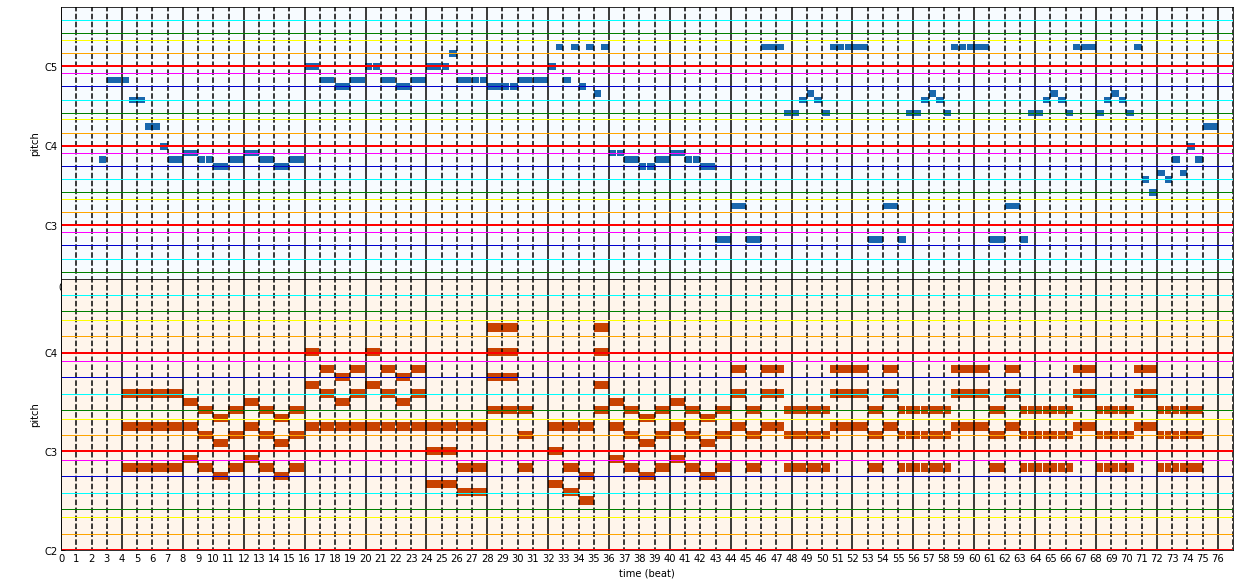

In [17]:
transpose = Transpose()

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

print(f"original_key: {bundles[0].meta['original_key']}")
grid_plot(ppr)

0.004874


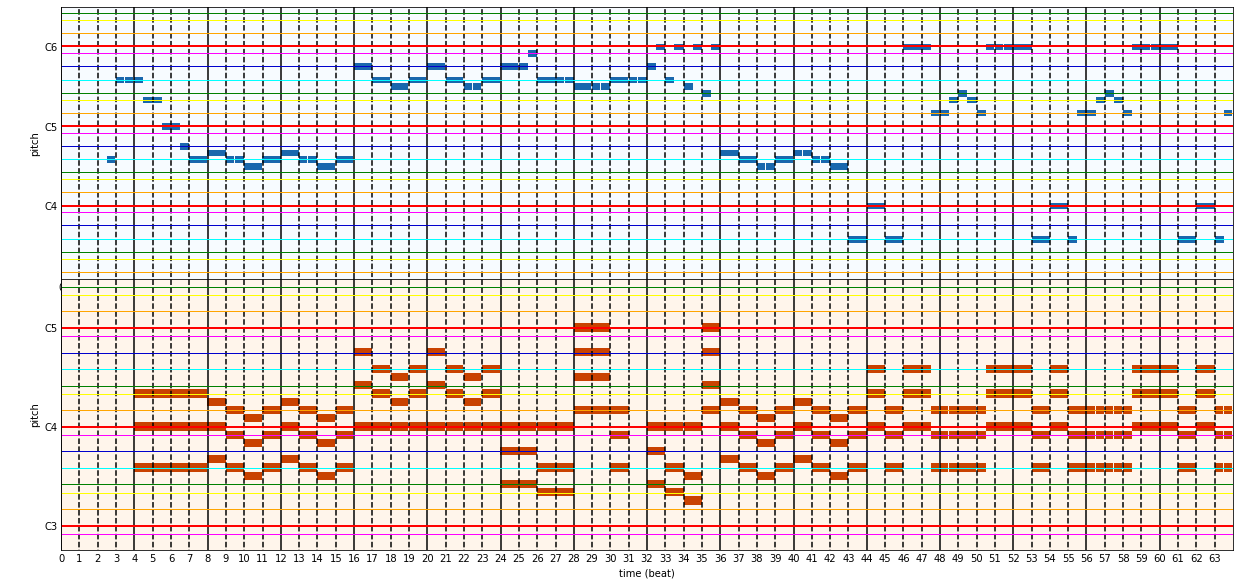

In [18]:
with Timer():
    bundles = transpose(bundles)

print(bundles[0].)
ppr.tracks[0].pianoroll = bundles[0].melody
ppr.tracks[1].pianoroll = bundles[0].chord
grid_plot(ppr)

### メロディをC3~D#7の中にシフト
例によってロスの少ないC3～D#7 (36,99)の中に「全体を」シフト  
一応注意: pretty_midiのpitch=0はC-1でpypianorollのplotのpitch=0はC-2だった

In [19]:
class TrimMelodyInRange(BundlesProcessor):
    def __init__(self, bottom, top):
        if bottom < 0 or top > 127:
            raise ValueError("Pitch range must be in [0, 127].")
        if top - bottom < 12:
            raise ValueError("Pitch range must be larger than 12 pitches.")
        self.bottom, self.top = bottom, top
    
    def process_bundle(self, bundle):
        nproll = bundle.melody
        bottom, top = self.bottom, self.top
                
        lower_step, lower_pitches = np.where(nproll[:, :bottom])
        new_lower_pitches = lower_pitches - (lower_pitches - bottom) // 12 * 12
        nproll[lower_step, new_lower_pitches] = nproll[lower_step, lower_pitches]
        nproll[lower_step, lower_pitches] = 0
        
        higher_step, higher_pitches_from_top = np.where(nproll[:, top+1:])
        higher_pitches = higher_pitches_from_top + (top + 1)
        new_higher_pitches = higher_pitches - (higher_pitches_from_top + 13) // 12 * 12
        nproll[higher_step, new_higher_pitches] = nproll[higher_step, higher_pitches]
        nproll[higher_step, higher_pitches] = 0
        
        bundle.melody = nproll[:, bottom:top+1]
        
        return bundle

動作確認

In [ ]:
bottom, top = 36, 99
trim_melody_in_range = TrimMelodyInRange(bottom, top)

short_path = "q/queen/bohemian-rhapsody/pre-chorus-and-chorus_key.mid" # 2 bars file
long_path = "q/queen/bohemian-rhapsody/bridge_key.mid" # 19 bars_file
ppr, row = sampler.ppr_by_path(long_path)
bundles = bundler.bundle(ppr, row)

print(f"original_key: {bundles[0].meta['original_key']}")
grid_plot(ppr)